most of the imports are fairly common Python libraries with a couple exceptions

- tqdm is a third-party library that helps with tracking how long a loop will take to run
- pmdarima is a third party library that's really just a wrapper of the statsmodel ARIMA, SARIMA, and SARIMAX classes to streamline the functionality and an optimized model auto-fitting procedure

In [198]:
#imports
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import statsmodels.api as sm
import pmdarima as pm
from sklearn.metrics import mean_squared_error
from dateutil import parser
import datetime
import time
import tqdm

The helper functions pretty much all just help me re-format and join the MISO data on DA forecasted flows and then actual flows at the interfaces. They get used when we go trawl MISO's website to download data in the next couple cells.

In [199]:
### HELPER FUNCTIONS ###
#helper functions for cleaning miso data
def date_creator(pd_datetime):
    month = str(pd_datetime.month)
    day = str(pd_datetime.day)
    if len(month)<2:
        month = '0'+month
    if len(day)<2:
        day = '0'+day
    return str(pd_datetime.year)+month+day

def create_daylist(daybegin,dayend):
    mylist = []
    for i in range(pd.Timedelta(dayend-daybegin).days):
        mystr = str(i)+' days'
        mydatetime = daybegin+pd.Timedelta(mystr)
        mylist.append(mydatetime)
    return mylist

def clean_dataframe(df,date):
    df.rename(columns={'Unnamed: 1':'Hour'},inplace=True)
    df.dropna(subset = ['Hour'],inplace=True)
    df.dropna(how='all',axis=1,inplace=True)
    df.dropna(inplace=True)
    #df.dropna(subset=['PJM'],inplace=True)
    #df.set_index('Hour',inplace=True)
    df['Date'] = [date]*len(df.index)
    return df

#helper functions for joining MISO data
def reshape_interface_df(df):
    #df.reset_index(inplace=True)
    l1 = []
    l2 = []
    for i in df.index:
        l1.extend([df.loc[i,'MKTDAY']]*24)
        l2.extend(list(df.loc[i,:])[2:])
    return(l1,l2)

def convert_dates(date_string):
    date_string = re.sub(r'/0', '/', date_string)
    if date_string[0]=='0':
        date_string = date_string[1:]
    return date_string


Pull xls files from MISO's website that have DA forecast flows on major interfaces. Code gives you a bit of progress updates (takes a few minutes to run)

In [224]:
#this cell takes awhile to run so be careful
#tqdm will help update you on how long it is expected to take to run
frame_list = []
for d in tqdm.notebook.tqdm(create_daylist(datetime.date(2017, 1, 1),datetime.date(2020, 4, 2))):
    if d.day==1 and d.month==1:
        print('starting: '+datetime.date(1900, int(d.month), 1).strftime('%B')+' '+str(d.year))
    mydate = date_creator(d) 
    myurl = 'https://docs.misoenergy.org/marketreports/'+str(mydate)+'_sr_nd_is.xls'
    data = pd.read_excel(myurl,'Sheet1',skiprows=10)
    df_clean = clean_dataframe(data,d+pd.Timedelta('1 days'))#needs to be one day ahead bc forecast is for next day
    frame_list.append(df_clean)
    time.sleep(.1) #100ms between calls to MISO's website
NextDayNSI_df = pd.concat(frame_list, ignore_index=True)
NextDayNSI_df.to_csv('miso_nsi.csv')

starting: January 2017
starting: January 2018
starting: January 2019
starting: January 2020



Then also grab the historical actual flows on these interfaces as recorded. This is quicker since MISO makes this hourly data available as single annual csvs rather than daily xls files.

In [226]:
#grab historical NSI data from miso website
f_list = []
for y in [2017,2018,2019,2020]:
    link = 'https://docs.misoenergy.org/marketreports/'+str(y)+'_sr_hist_is.csv'
    data = pd.read_csv(link,sep='|',skiprows=1)
    f_list.append(data)
    time.sleep(.2)
HistoricalNSI_df = pd.concat(f_list, ignore_index=True)
HistoricalNSI_df.head()

,INTERFACE,MKTDAY,HE1,HE2,HE3,HE4,HE5,HE6,HE7,HE8,...,HE15,HE16,HE17,HE18,HE19,HE20,HE21,HE22,HE23,HE24
0,CSWS,01/01/2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,EDE,01/01/2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,EEI,01/01/2017,379.0,205.0,145.0,145.0,145.0,145.0,145.0,145.0,...,145.0,145.0,275.0,405.0,405.0,405.0,405.0,405.0,389.0,390.0
3,IESO,01/01/2017,1542.0,1566.0,1566.0,1620.0,1621.0,1532.0,1623.0,1626.0,...,1621.0,1581.0,1524.0,1624.0,1426.0,1246.0,1377.0,1380.0,1375.0,1387.0
4,MHEB,01/01/2017,622.0,645.0,668.0,499.0,671.0,632.0,1248.0,1312.0,...,1247.0,1216.0,1117.0,1106.0,988.0,972.0,1017.0,1039.0,1074.0,802.0


This just joins the DA forecast and then actual flows on the various interfaces into a single dataframe in a comparable format. 

In [234]:
df_dict = {}
for c in NextDayNSI_df.columns:
    if c in HistoricalNSI_df['INTERFACE'].unique():
        shaped_lists = reshape_interface_df(HistoricalNSI_df[(HistoricalNSI_df['INTERFACE']==c) & (HistoricalNSI_df['MKTDAY']!='01/01/2017')])
        if c=='EEI':
            clean_shaped_list = [convert_dates(d) for d in shaped_lists[0]]
            df_dict['Date2'] = clean_shaped_list
            mylength = len(clean_shaped_list)
        if len(shaped_lists[1]) == mylength:
            df_dict[c+'Historical'] = shaped_lists[1]
        
df_to_merge = pd.DataFrame.from_dict(df_dict)
merged_NSI = pd.concat([NextDayNSI_df, df_to_merge], axis=1, sort=False)
merged_NSI_noNA = merged_NSI.dropna(subset=['PJMHistorical'])
merged_NSI_noNA.head()

,Hour,EEI,IESO,MHEB,PJM,SOCO,SWPP,TVA,WAUE,Other,Total,Date,Date2,EEIHistorical,IESOHistorical,MHEBHistorical,PJMHistorical,SOCOHistorical,SWPPHistorical,TVAHistorical
0,Hour 1,210.0,1332.0,50.0,1919.0,-2.0,818.0,181.0,0.0,192.0,4700,2017-01-02,1/2/2017,210.0,1462.0,591.0,1866.0,14.0,743.0,181.0
1,Hour 2,145.0,1386.0,221.0,1870.0,46.0,866.0,181.0,0.0,179.0,4894,2017-01-02,1/2/2017,145.0,1614.0,590.0,1816.0,46.0,866.0,181.0
2,Hour 3,145.0,1386.0,297.0,1870.0,48.0,862.0,181.0,0.0,181.0,4970,2017-01-02,1/2/2017,145.0,1603.0,546.0,1818.0,48.0,862.0,181.0
3,Hour 4,145.0,1415.0,297.0,1870.0,47.0,862.0,181.0,0.0,184.0,5001,2017-01-02,1/2/2017,145.0,1489.0,473.0,1817.0,81.0,862.0,181.0
4,Hour 5,145.0,1415.0,333.0,1570.0,47.0,859.0,181.0,0.0,184.0,4734,2017-01-02,1/2/2017,145.0,1513.0,595.0,1536.0,227.0,859.0,181.0


## ARIMA

Chose to do ARIMA model with exogenous regresor for the DA predicted load in the hour. The model chooses its other parameters in a grid search process in the code and by default does not assume any seasonality (though this can easily be added). 

Useful links where some code was taken:

- [pmdarima documentation](https://alkaline-ml.com/pmdarima/index.html)
- [ARIMA time series forecasting using pmdarima](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/)

There are a bunch of other links I looked at a bit on ARIMA models. Google is probably fine, but [here's](https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c) another that's a little simpler. 

I essentially run the model two different ways to allow different two differnt levels of visibility, which will get explained, but there's flexibility to do much more, particularly if there's some intuition about seasonality in interchange at some/all interfaces or additional exogenous factors the model could include (e.g., temperature, something known about dispatch conditions in PJM or TVA, etc.). 

The two levels of visibility for the model are essentially hourly and daily. Hourly meaning the model knows everything that's occurred up to the dispatch hour (most relevantly, it then knows how innaccurate the DA interchange forecast was in the previous hour). Daily means the model only knows up to what happened 24 hours before (i.e., it's forecasting off how innaccurate the DA forecast was yesterday, as well as knowing the DA forecast for today). 

In [250]:
class arima_model():
    def __init__(self,df,col,train_pct):
        self.df = df
        self.col = col
        self.train_pct = train_pct
        if len(df['Hour'].unique())==1:
            self.time_label = 'Day'
            self.hour_label = 'HE'+df['Hour'].unique()[0].replace('Hour  ','')
            self.hour_label_2 = self.hour_label
        else:
            self.time_label = 'Hour'
            self.hour_label = 'All Hours'
            self.hour_label_2 = 'HE1'
                 
    def train_test_split(self):
        split_position = int(len(self.df.index)*self.train_pct)
        self.train_df = self.df.iloc[:split_position,:]
        self.test_df = self.df.iloc[split_position:,:]
    def train_arima_model(self,replace_string,delta_col='Historical',is_delta=False):
        self.replace_string = replace_string
        self.delta_col = delta_col
        
        if is_delta==True:
            print('replacing')
            self.train_df[self.delta_col] = self.train_df[self.col] - self.train_df[self.col.replace('Historical',replace_string)] #something optional here to replace the relevant column
            self.test_df[self.delta_col] = self.test_df[self.col] - self.test_df[self.col.replace('Historical',replace_string)]
            self.col = self.delta_col
            self.replace_string = 'PJMZero'
        
        self.m1 = pm.auto_arima(self.train_df[[self.col]],
                      exogenous=self.train_df[[self.col.replace(self.delta_col,self.replace_string)]], 
                      start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

        print(self.m1.summary()) #summary of chosen
        self.m1.plot_diagnostics(figsize=(12,8)) #diagnostic plot
        plt.show()
        
    def forecast_one_step(self,exog): #allows serialization of forecast
        fc, conf_int = self.m1.predict(n_periods=1, exogenous=exog, return_conf_int=True)
        return (fc.tolist()[0],np.asarray(conf_int).tolist()[0])
        
    def get_model_error(self):
        #train error
        try:
            self.interface_label = self.col.replace(self.delta_col,self.replace_string)
        except AttributeError:
            print('run these in order, likely problem')
            self.train_arima_model('')
            
        self.train_np = np.asarray(self.train_df[self.col])
        train_df_repl = self.train_df[self.col.replace(self.delta_col,self.replace_string)]
        self.train_forecast = np.asarray(train_df_repl)
        self.train_preds, self.train_ci = self.m1.predict_in_sample(n_periods=self.train_np.shape[0],
                                                                    exogenous=np.tile(train_df_repl, 2).reshape(-1,1),
                                                                    return_conf_int=True)
        #print the train error
        print("Train RMSE: %.3f" % np.sqrt(mean_squared_error(self.train_np, self.train_preds)))
        print("DA Forecast RMSE on train data: %.3f" % np.sqrt(mean_squared_error(self.train_np,self.train_forecast)))
        print('Train MAPE: %.2f'% np.mean(np.abs(self.train_preds - self.train_np)/np.abs(self.train_np)))  # MAPE
        
        #test error
        self.test_np = np.asarray(self.test_df[self.col])
        test_df_repl = self.test_df[self.col.replace(self.delta_col,self.replace_string)]
        self.test_forecast = np.asarray(test_df_repl)
        
        #serialize the test preds
        test_forecasts = []
        test_confidence_intervals = []

        for new_ob_index in tqdm.notebook.tqdm(self.test_df.index):
            new_ob = self.test_df.loc[new_ob_index,self.col]
            new_exog = np.tile(self.test_df[[self.col.replace(self.delta_col,self.replace_string)]].loc[new_ob_index,:],1).reshape(-1,1)
            fc, conf = self.forecast_one_step(new_exog)
            test_forecasts.append(fc)
            test_confidence_intervals.append(conf)
            self.m1.update(new_ob,new_exog)
        self.test_preds = np.asarray(test_forecasts)
        self.test_ci = np.asarray(test_confidence_intervals)
        
        # Print the test error:
        print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(self.test_np, self.test_preds)))
        print("DA Forecast RMSE: %.3f" % np.sqrt(mean_squared_error(self.test_np,self.test_forecast)))
        print('Test MAPE: %.2f'% np.mean(np.abs(self.test_preds - self.test_np)/np.abs(self.test_np)))  # MAPE
        
    def train_test_plot(self):
        fig,ax=plt.subplots(3,1,figsize=(16,8))
        x = np.arange(self.train_np.shape[0] + self.test_np.shape[0])
    
        # Plot the predictions with the historical
        ax[0].plot(x[:self.train_np.shape[0]], np.asarray(self.train_df[self.col]), c='b',label='Historical Actual')
        ax[0].plot(x[self.train_np.shape[0]:], self.test_preds, c='r',linestyle='dashed',label = 'Predictions')
    
        lower_series = np.asarray(self.test_ci[:, 0])
        upper_series = np.asarray(self.test_ci[:, 1])

        ax[0].fill_between(x[self.train_np.shape[0]:], lower_series, upper_series, 
                 color='k', alpha=.15,label='Prediction CI')
        ax[0].set_title(self.interface_label+' Interface historical flows and ARIMA-forecast future flows for '+self.hour_label)
        ax[0].set_ylabel('MW',fontdict={'fontsize': '14'})
        ax[0].set_xlabel(self.time_label+'s Since 1/2/2017 '+self.hour_label_2,fontdict={'fontsize': '14'})
        ax[0].legend(loc='upper left')
        
        # Plot only the test predictions with the actuals as well as the PJMHist
        ax[1].plot(x[self.train_np.shape[0]:], 
               self.test_preds, c='r',linestyle='dashed',label='Predictions')
        ax[1].plot(x[self.train_np.shape[0]:], 
               np.asarray(self.test_df[self.col.replace(self.delta_col,self.replace_string)]),c='g',label='DA Forecast')
        ax[1].plot(x[self.train_np.shape[0]:],
               np.asarray(self.test_df[self.col]),c='b',label='Actual')
        ax[1].fill_between(x[self.train_np.shape[0]:], lower_series, upper_series, 
                 color='k', alpha=.15,label='Prediction CI')
        ax[1].set_title('Test predictions with comparison v. DA forecast')
        ax[1].set_ylabel('MW',fontdict={'fontsize': '14'})
        ax[1].set_xlabel(self.time_label+'s Since 1/2/2017 '+self.hour_label_2,fontdict={'fontsize': '14'})
        ax[1].legend()
    
        # Plot only the train predictions with the actuals as well as the PJMHIst
        ax[2].plot(x[:self.train_np.shape[0]], 
               self.train_preds, c='r',linestyle='dashed',label='Predictions')
        #ax[2].plot(x[:model_tuple[1][model_tuple[-1]].shape[0]], 
        #           np.asarray(model_tuple[1][model_tuple[-1].replace('Historical','')]),c='g',label='forecast')
        ax[2].plot(x[:self.train_np.shape[0]],
               np.asarray(self.train_df[self.col]),c='b',label='Actual')
        ax[2].set_title('Training predictions only')
        ax[2].set_xlabel(self.time_label+'s Since 1/2/2017 '+self.hour_label_2,fontdict={'fontsize': '14'})
        ax[2].set_ylabel('MW',fontdict={'fontsize': '14'})
        ax[2].legend()
        plt.tight_layout()
        plt.show()

### Comments

First version of model will only run for a single-hour subset. This is one simple way of making it so that the model as **NO** foresight into what's actually occurring in the day it's forecasting. It's only working off the DA Forecast as well as the actual interchange during the same hour in previous days (i.e., if it's HE20 4/1/2020 for the PJM Interface, the model knows what the interchange was at the PJM Interface in HE20 on 3/31/2020, 3/30/2020, and as many days back as the ARIMA fit selects as optimal). 

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=16386.426, BIC=16411.151, Time=0.657 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=16626.191, BIC=16641.026, Time=0.313 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=16447.222, BIC=16467.002, Time=0.081 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=16509.280, BIC=16529.060, Time=0.352 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=16712.630, BIC=16722.520, Time=0.301 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=16349.946, BIC=16379.617, Time=1.099 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=16428.908, BIC=16453.634, Time=0.117 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=16351.687, BIC=16386.303, Time=1.488 seconds
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=16351.160, BIC=16385.775, Time=1.393 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1

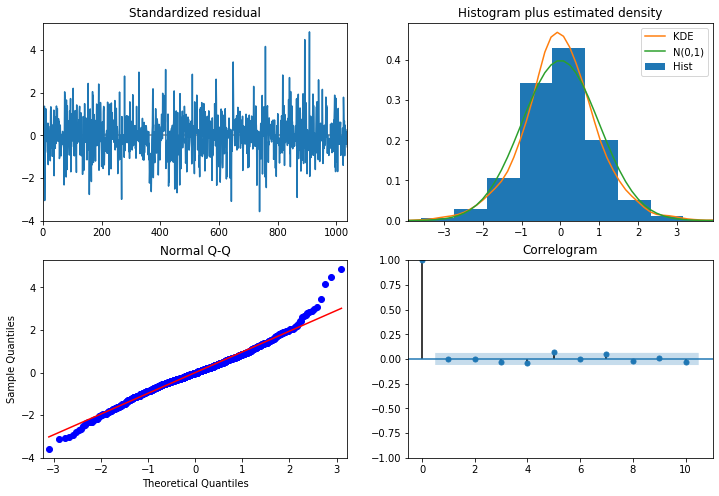

Train RMSE: 632.884
DA Forecast RMSE on train data: 758.619
Train MAPE: 1.39


C:\Users\llavi\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)



Test RMSE: 912.325
DA Forecast RMSE: 918.701
Test MAPE: 0.81


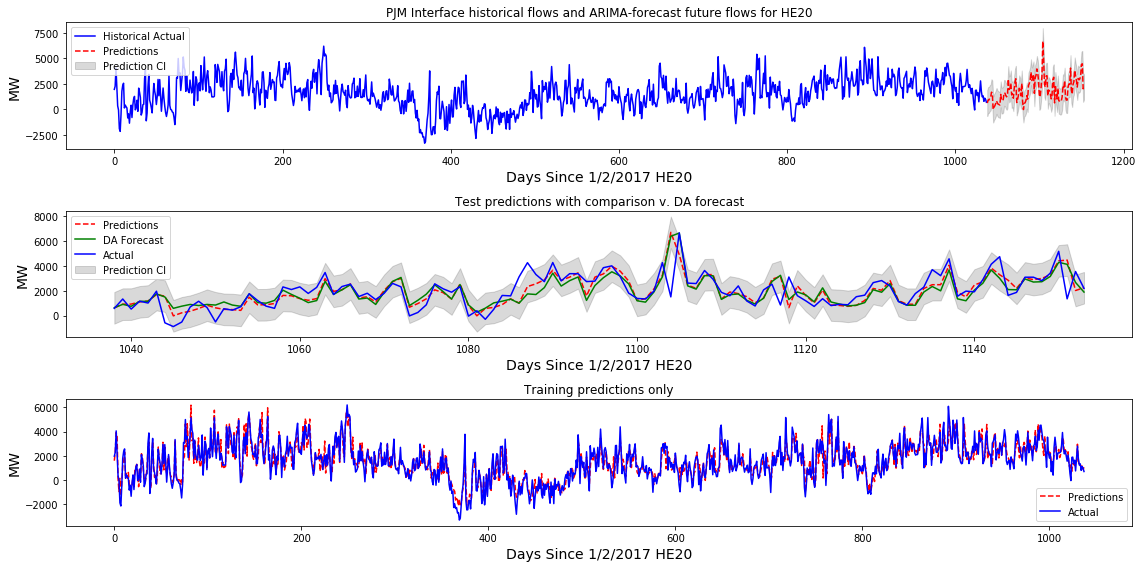

In [251]:
#creates and runs model
#hourly on this first one - doesn't really matter what the Hour Ending is
class_arima = arima_model(merged_NSI_noNA[merged_NSI_noNA['Hour']=='Hour  20'],'PJMHistorical',.9)
class_arima.train_test_split()
class_arima.train_arima_model('')
class_arima.get_model_error()
class_arima.train_test_plot()

### Comments
Honestly, the performance of this model vs. the DA forecast doesn't appear to offer a lot. It's maybe a little more accurate, depending on the interface, but mostly it just ends up taking the DA forecast and applying it (the best-fit coefficient for the DA forecast is .9474 for PJM). 

In terms of the diagnostics for the model, the skewing (non-normality) of the QQplot is a little concerning but perhaps not overly so. The RMSE ends up being a more useful error metric than MAPE as there are enough near-zero MW interchange hours that this messes up the MAPE. RMSE will be fine as long as we remember to be careful when comparing errors across interfaces since they may have quite different magnitudes of average interchange with MISO.

Let's assume the model can instead be updated throughout the day (i.e., at least hourly) to know how inaccurate the DA forecast was in the previous hour, not just the previous day.

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=394825.015, BIC=394866.150, Time=17.910 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=445240.243, BIC=445264.924, Time=9.041 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=394939.486, BIC=394972.394, Time=11.162 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=422070.569, BIC=422103.477, Time=14.217 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=701686.727, BIC=701703.181, Time=0.481 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=394810.627, BIC=394859.989, Time=23.763 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=394818.410, BIC=394859.546, Time=17.566 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=394870.187, BIC=394927.776, Time=29.579 seconds
Near non-invertible roots for order (3, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of 

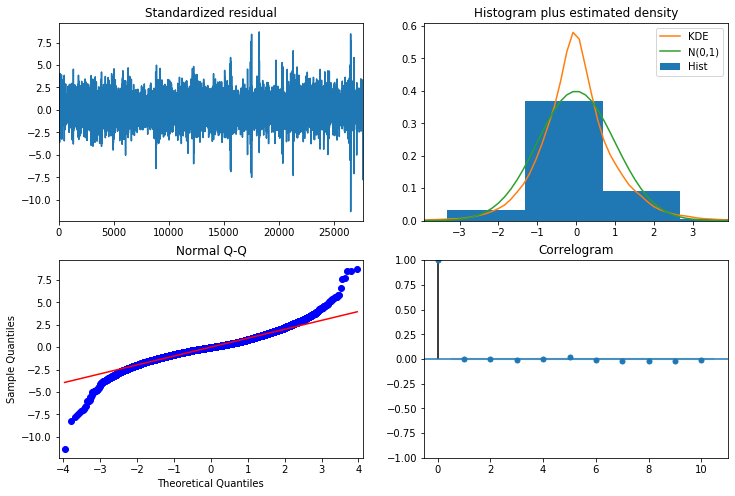

Train RMSE: 302.434
DA Forecast RMSE on train data: 785.116
Train MAPE: inf


C:\Users\llavi\Anaconda4\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in true_divide



Test RMSE: 561.187
DA Forecast RMSE: 1001.135
Test MAPE: 0.15


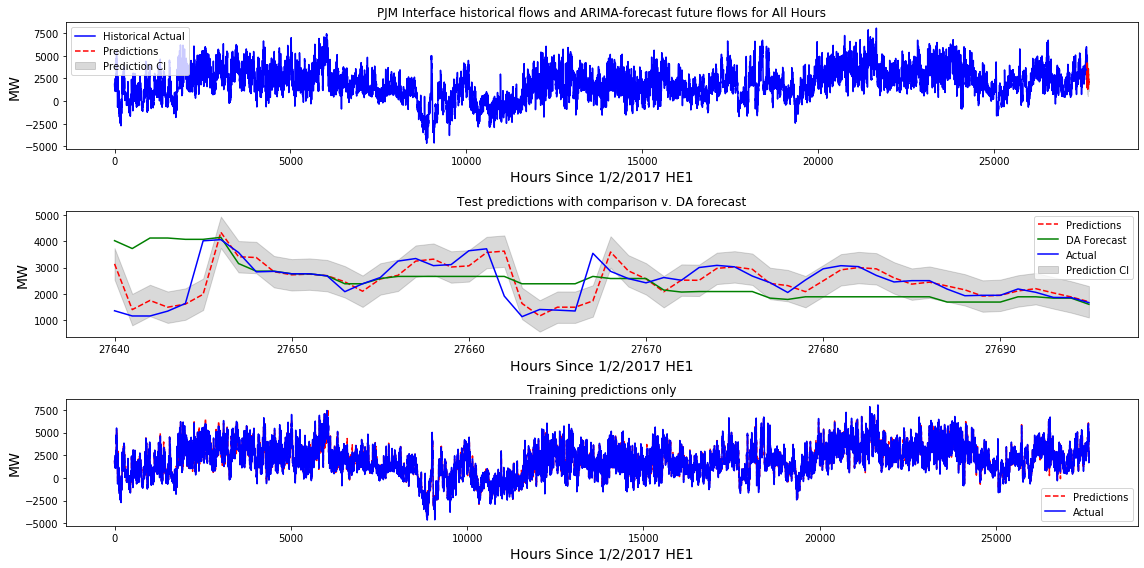

In [252]:
#merged_NSI_noNA = merged_NSI.dropna(subset=['PJMHistorical'])
class_arima = arima_model(merged_NSI_noNA,'PJMHistorical',.998)
class_arima.train_test_split()
class_arima.train_arima_model('')
class_arima.get_model_error()
class_arima.train_test_plot()

### Comments

Now we see a real improvement in performance - the ARIMA has about half the train and test error (measured by RMSE) of the DA forecast. 

Last case for now just shows the model can easily be run on another interface (will choose IESO here) and extended to run more hours in its test set without much reduction in accuracy. Note that the model must re-update every hour (since it needs to know exactly what went on in the previous hour, so it needs to move hours into its historical dataset as it goes), which is what causes the full set of forecasts to take a little while to run. Once the model is trained and for a single hour it'd only take a second or less to run.

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=338953.995, BIC=338995.039, Time=28.610 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=377432.683, BIC=377457.310, Time=9.905 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=339054.806, BIC=339087.641, Time=22.136 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=359301.408, BIC=359334.244, Time=13.015 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=378964.532, BIC=378980.949, Time=7.901 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=337699.538, BIC=337748.791, Time=18.396 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=339823.857, BIC=339864.901, Time=14.368 seconds
Near non-invertible roots for order (2, 0, 0)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=337867.277, BIC=337924.7

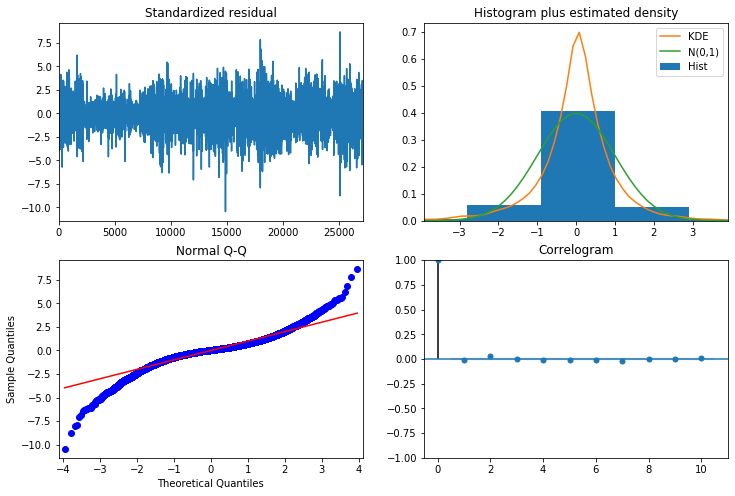

Train RMSE: 121.746
DA Forecast RMSE on train data: 286.005
Train MAPE: inf


C:\Users\llavi\Anaconda4\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in true_divide



Test RMSE: 121.492
DA Forecast RMSE: 335.046
Test MAPE: 0.06


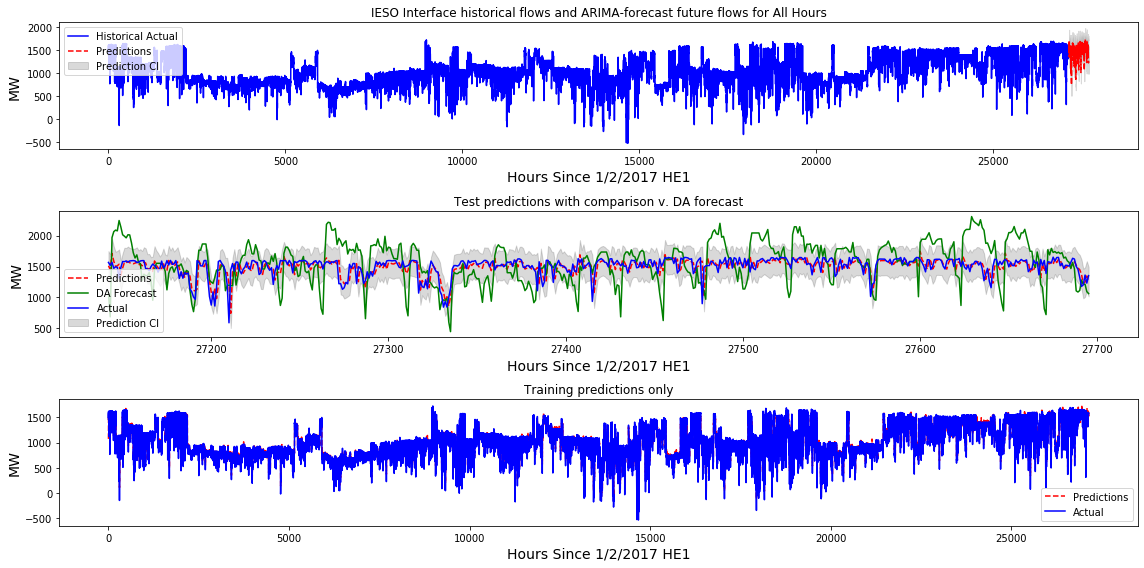

In [253]:
class_arima = arima_model(merged_NSI_noNA,'IESOHistorical',.98)
class_arima.train_test_split()
class_arima.train_arima_model('')
class_arima.get_model_error()
class_arima.train_test_plot()

IESO offers an even more sizable gain over DA forecast. Not 100% sure why - my mental heuristic about Canada is it's a lot of hydro, but I think that's more BC and Quebec than Ontario. As I recall Ontario has a lot of nuclear. Regardless, it does appear there's more hour-to-hour correlation in flows with MISO, which the ARIMA model can do a better job picking up than the DA forecast. It's a bit hard to explain why the DA forecast includes some scheduled interchanges of over 2GW in the historical dataset when actuals never go above 1.7 GW or so. 

Fin (for now)